In [ ]:
# def fetchData():
#     line = file.readline()
#     cnt = 0

#     while cnt < 10000:
#         if not line: break
#         if cnt > 0: line = file.readline()
#         cnt += 1

#         authors = []
#         year = ''
#         conf = ''

#         for i in range(7):
#             if i == 1: authors = line[2:-1].split(',')
#             if i == 2: year = line[5:-1]
#             if i == 3: conf = line[5:-1]
#             line = file.readline()

#         while not line or not(line == '\n'): line = file.readline()

#         if nodes.get(conf) == None:
#             nodes[conf] = len(nodes.keys())
#             node_type_list.append(1)
#         conf_id = nodes.get(conf)

#         author_ids = []
#         for author in authors:
#             if nodes.get(author) == None:
#                 nodes[author] = len(nodes.keys())
#                 node_type_list.append(0)
#             author_id = nodes[author]
#             author_ids.append(author_id)
#             edge_list.append([str(author_id),'0',str(conf_id),'1','0',year])
#             edge_list.append([str(conf_id),'1',str(author_id),'0','2',year])  #******************

#             if node_edge_map.get(str(conf_id)) == None:
#               node_edge_map[str(conf_id)] = {}
#             if node_edge_map[str(conf_id)].get(year) == None:
#               node_edge_map[str(conf_id)][year] = []

#             if node_edge_map.get(str(author_id)) == None:
#               node_edge_map[str(author_id)] = {}
#             if node_edge_map[str(author_id)].get(year) == None:
#               node_edge_map[str(author_id)][year] = []


#             node_edge_map[str(conf_id)][year].append(str(author_id))
#             node_edge_map[str(author_id)][year].append(str(conf_id))

#         for i in author_ids:
#             for j in author_ids:
#                 if i == j: continue
#                 if i < j: edge_list.append([str(i),'0',str(j),'0','1',year]) # remove cond later
#                 node_edge_map[str(i)][year].append(str(j))

In [ ]:
!pip install cdlib leidenalg python-igraph littleballoffur pyvis

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
%cd /content/gdrive/MyDrive/hpge/

/content/gdrive/MyDrive/hpge


In [ ]:
import tensorflow as tf
import pickle as pkl
import networkx as nx
from cdlib import algorithms
import leidenalg
import matplotlib.pyplot as plt
import numpy as np
import igraph as ig
import os
import multiprocessing
from littleballoffur import CirculatedNeighborsRandomWalkSampler, CommonNeighborAwareRandomWalkSampler, NonBackTrackingRandomWalkSampler, LoopErasedRandomWalkSampler, RandomWalkSampler, MetropolisHastingsRandomWalkSampler

from write_year_wise import writeYearWise

Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer', 'bayanpy', 'graph_tool'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'pyclustering'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer'}


In [ ]:
def indexEdges(node_to_index_map, index_to_node_map, edges):
  cnt = 0
  for edge in edges:
    u = edge[0]
    v = edge[2]

    if node_to_index_map.get(u) == None:
      node_to_index_map[u] = cnt
      index_to_node_map[cnt] = u
      cnt += 1
    if node_to_index_map.get(v) == None:
      node_to_index_map[v] = cnt
      index_to_node_map[cnt] = v
      cnt += 1
  return cnt

In [ ]:
def getEdgeFromMap(node_type_map, year, edge, index_map):
  u = index_map[edge[0]]
  v = index_map[edge[1]]
  u_type = node_type_map[u]
  v_type = node_type_map[v]

  # -------------/////////-------------- might need to change incase no. of edges is more ---------------/////////------------------
  e_type = '0' if u_type == v_type else '1'

  return [u, u_type, v, v_type, e_type, year]

In [ ]:
# Define a function to execute sampler.sample with a timeout
skipped_years = []
def sample_with_timeout(sampler, year, graph, timeout):
    try:
        return sampler.sample(graph)
    except multiprocessing.TimeoutError:
        print(f"Timeout occurred for {method}")
        skipped_years.append(year)
        return None

def readEdgesFromFile(filepath, edgeMap, year, sampling_models):
  edge_map[year] = {}
  node_type = {}
  edge_file = open(filepath, 'r')
  edges = []
  line = edge_file.readline()
  cnt = 0

  while line:
    edge = line[:-1].split(',')
    if len(edge) == 6:
      node_type[edge[0]] = edge[1]
      node_type[edge[2]] = edge[3]
      edges.append(edge)
    line = edge_file.readline()
    cnt += 1

  node_to_index_map = {}
  index_to_node_map = {}
  node_count = indexEdges(node_to_index_map, index_to_node_map, edges)

  graph = nx.Graph()
  graph.add_edges_from([(node_to_index_map[edge[0]], node_to_index_map[edge[2]]) for edge in edges])

  for method in sampling_models.keys():
    sampler = sampling_models[method](1000)
    if node_count > 1000:
        # Execute sampler.sample with a timeout of 10 seconds (adjust as needed)
        result = None
        with multiprocessing.Pool(processes=1) as pool:
            async_result = pool.apply_async(sample_with_timeout, (sampler,year, graph), {"timeout": 2*60})
            try:
                result = async_result.get(timeout=10)
            except multiprocessing.TimeoutError:
                print(f"Timeout occurred for {method} {year}")

        if result:
            edgeMap[year][method] = list(getEdgeFromMap(node_type, year, edge, index_to_node_map) for edge in result.edges())
        else:
            edgeMap[year][method] = []
    else: edgeMap[year][method] = edges

In [ ]:
use_data_files = True
use_sampling = True
year_list = os.listdir('data/year_wise')
print(year_list)

['.ipynb_checkpoints', '1957', '1940', '1955', '1952', '1954', '1945', '1956', '2010', '1951', '2011', '1012', '2013', '2012', '1943', '1944', '1946', 'bron JA,Bonilla LL,Vicente CJP', '1947', '1939', '1948', '1942', '1937', '1941', '1938', '1958', '1936', '1974', '1979', '1975', '1949', '1969', '1973', '1968', '1971', '1967', '1972', '1970', '1963', '1953', '1950', '1965', '1960', '1966', '1964', '1961', '1962', '1959', '2004', '2008', '2007', '1995', '1988', '1994', '1989', '1997', '2000', '1986', '1996', '1984', '2002', '1999', '1987', '1983', '2003', '2001', '2009', '1993', '1992', '1990', '1991', '2005', '1998', '1977', '1981', '1982', '1985', '1976', '1978', '1980', '2006']


In [ ]:
edge_map = {}
sampling_models = {
    # 'cnrs': CirculatedNeighborsRandomWalkSampler,
    # 'cnars': CommonNeighborAwareRandomWalkSampler,
    # 'nbtrs': NonBackTrackingRandomWalkSampler,
    # 'lers': LoopErasedRandomWalkSampler,
    'rs': RandomWalkSampler,
    # 'mhrs': MetropolisHastingsRandomWalkSampler
}

In [ ]:
# if use_data_files:
for year in year_list:
  if not(year == '.ipynb_checkpoints'): readEdgesFromFile('data/year_wise/' + year, edge_map, year, sampling_models)
# else:
#   for edge in edge_list:
#     if edge_map.get(edge[5]) == None: edge_map[edge[5]] = []

#     edge_map[edge[5]].append(edge)

Timeout occurred for rs 1980


In [ ]:
nodes = {}
nodes['dummy_node'] = 0
edge_list = []
node_type_list = []
node_edge_map = {} # {node_id -> {timestamp -> [adj nodes]} }
# edge_list - [s_id,s_type,t_id,t_type,e_type,year]
# sid, s_type, tid, t_type, e_type, timestamp

In [ ]:
def fetchData(smp_method = 'rs'):
  for year in year_list:
    if year == '.ipynb_checkpoints': continue
    for edge in edge_map[year][smp_method]:

      if nodes.get(edge[0]) == None:
        nodes[edge[0]] = len(nodes.keys())
        node_type_list.append(edge[1])

      if nodes.get(edge[2]) == None:
        nodes[edge[2]] = len(nodes.keys())
        node_type_list.append(edge[3])

      u = nodes[edge[0]]
      v = nodes[edge[2]]

      if node_edge_map.get(str(u)) == None:
        node_edge_map[str(u)] = {}
      if node_edge_map[str(u)].get(year) == None:
        node_edge_map[str(u)][year] = []

      if node_edge_map.get(str(v)) == None:
        node_edge_map[str(v)] = {}
      if node_edge_map[str(v)].get(year) == None:
        node_edge_map[str(v)][year] = []

      node_edge_map[str(u)][year].append(v)
      node_edge_map[str(v)][year].append(u)
      edge_list.append([str(u), edge[1], str(v), edge[3], edge[4], year])

In [ ]:
def writeData(filename, edge_list):
    # sid, s_type, tid, t_type, e_type, timestamp
    with open(filename,"w") as data_file:

        for edge in edge_list:
            data_file.write(','.join(edge))
            data_file.write("\n")

In [ ]:
fetchData()
print("Number of edges",len(edge_list))
print("Number of nodes", len(nodes.keys())-1)

Number of edges 85879
Number of nodes 29899


In [ ]:
edge_list[0]

['1', '0', '2', '1', '0', '1957']

In [ ]:
writeData("data_file.txt",  edge_list)

In [ ]:
from data_loader import DataLoader

In [ ]:
dl_obj = DataLoader("data_file.txt", 5, 5, 3, ',', 'important')
# (file_path, nbr_size, neg_size, num_edge_types,delim,sample_type)

1012 1001 29899 85879


In [ ]:
dl_obj.generate_training_dataset("dataset.txt", num_process=10)
# print(sid, s_type, tid, t_type, e_type, timestamp)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from input import input_func

data = input_func('dataset.txt',3,len(edge_list),5,5,";",",")
# (filename, num_edge_types, batch_size, neg_size=1, nbr_size=1,col_delim1=";", col_delim2=",")

In [ ]:
# print(data[2].dtype)
# data[0] = tf.cast(data[0], dtype = tf.int32)
# print(data[1].dtype)

In [ ]:
from new_model import HHP
global_step = tf.compat.v1.train.get_or_create_global_step()
model = HHP(global_step,0.001,len(edge_list),5,5,dl_obj.node_size,128,2,3,0.001)
# global_step, learning_rate, batch_size, neg_size, nbr_size, node_size, node_dim, num_node_types,
                #  num_edge_types,
                #  norm_rate

In [ ]:
ret = model.__call__(data)
print(len(ret))
print(model.loss(ret[0],ret[1],ret[2]))

3
tf.Tensor(2.3437614, shape=(), dtype=float32)


In [ ]:
@tf.function
def train_step(data):
    with tf.GradientTape() as tape:
        output = model.__call__(data)
        loss = model.loss(output[0],output[1],output[2])
    grads = tape.gradient(loss,model.trainable_variables)
    model.optimizer.apply_gradients(zip(grads,model.trainable_variables))
    return loss

In [ ]:
# training the model
y = []
x = []
def train(data,epochs):
    for e in range(epochs):
        loss = train_step(data)
        if e%5 == 0:
          print("Loss",loss)
          x.append(e)
          y.append(loss)

In [ ]:
train(data, 70)

Loss tf.Tensor(2.3437614, shape=(), dtype=float32)
Loss tf.Tensor(2.282617, shape=(), dtype=float32)
Loss tf.Tensor(2.2124548, shape=(), dtype=float32)
Loss tf.Tensor(2.1297545, shape=(), dtype=float32)
Loss tf.Tensor(2.0277007, shape=(), dtype=float32)
Loss tf.Tensor(1.9049395, shape=(), dtype=float32)
Loss tf.Tensor(1.792951, shape=(), dtype=float32)
Loss tf.Tensor(1.7197292, shape=(), dtype=float32)
Loss tf.Tensor(1.6490806, shape=(), dtype=float32)
Loss tf.Tensor(1.5865717, shape=(), dtype=float32)
Loss tf.Tensor(1.5375566, shape=(), dtype=float32)
Loss tf.Tensor(1.4950416, shape=(), dtype=float32)
Loss tf.Tensor(1.4560394, shape=(), dtype=float32)
Loss tf.Tensor(1.4192301, shape=(), dtype=float32)


Text(0, 0.5, 'Loss')

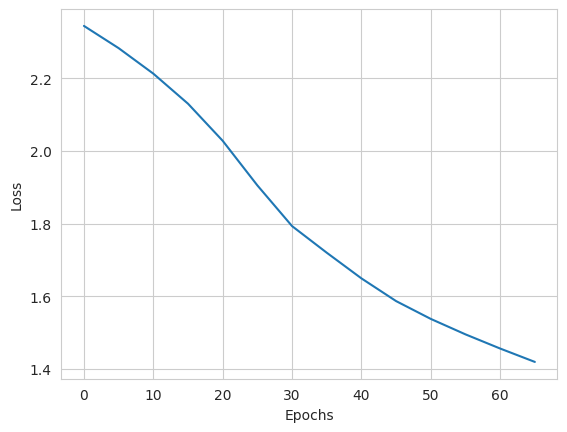

In [ ]:
import matplotlib.pyplot as plt

plt.plot(x,y)
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [ ]:
pkl.dump([model.embedding, model.edge_type_embed], open("embedding_file", "wb"))
tf.saved_model.save(model,'/')

In [ ]:
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, normalized_mutual_info_score, adjusted_rand_score, roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import pickle as pkl

In [ ]:
node_embed, _ = pkl.load(open("embedding_file", "rb"))

In [ ]:
node_embed = node_embed.numpy()
print(node_embed.shape)
print(node_embed[0], node_embed[0].shape)
x_train, x_valid, y_train, y_valid = train_test_split(node_embed, node_type_list, test_size=0.3,random_state=9)

(29899, 128)
[-0.03421486 -0.05465776 -0.02040797  0.05555383  0.04594859  0.04192892
 -0.0063376  -0.00499486  0.04968357  0.0020893   0.04540573 -0.00576121
 -0.06134605 -0.00551585  0.03386682 -0.05147639  0.04998088 -0.0424808
  0.03564182  0.01417476 -0.02365823 -0.01122447  0.02424565  0.05195735
 -0.02436225 -0.03493171  0.03204966  0.0145682  -0.02005909 -0.04401662
 -0.03680745  0.02792194  0.05358309  0.00878617  0.01728971 -0.01735857
 -0.03697526 -0.04888175 -0.00381697 -0.02952913  0.04864239  0.04554313
  0.01824257  0.0418576  -0.01787138 -0.02818408  0.05925549 -0.0191025
  0.04148508  0.04282953  0.02276985 -0.04294892 -0.00864586  0.02121151
 -0.02231286 -0.01733952  0.04557529 -0.01230494 -0.02276204 -0.00038434
 -0.01812156 -0.0332775  -0.03768408 -0.03795049  0.02750589 -0.00702521
  0.0167258  -0.03565258 -0.05219905  0.04370756 -0.03923576 -0.02517987
  0.02866128  0.01574625  0.02151651 -0.04413444 -0.0120346  -0.01512963
 -0.02423722 -0.0517917  -0.02472751  0.

In [ ]:

zero = []
one = []

for i in range(len(node_type_list)):
  if node_type_list[i] == '1': one.append(i)
  else: zero.append(i)

confs = np.repeat(node_embed[one], 12, axis = 0)
# confs = node_embed[one]
athrs = node_embed[zero]

cy = [1 for _ in range(confs.shape[0])]
ay = [0 for _ in range(athrs.shape[0])]

print(confs.shape, type(node_embed[0]))
print(athrs.shape)

cx_train, cx_valid, cy_train, cy_valid = train_test_split(confs, cy, test_size=0.3,random_state=9)
ax_train, ax_valid, ay_train, ay_valid = train_test_split(athrs, ay, test_size=0.4,random_state=9)

print(cx_train.shape, ax_train.shape)

x_train = np.append(cx_train,ax_train,axis = 0)
x_valid = np.append(cx_valid,ax_valid,axis = 0)
y_train = np.append(cy_train,ay_train,axis = 0)
y_valid = np.append(cy_valid,ay_valid,axis = 0)

(16140, 128) <class 'numpy.ndarray'>
(28554, 128)
(11298, 128) (17132, 128)


In [ ]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
y_valid_pred = lr.predict(x_valid)
micro_f1 = f1_score(y_valid, y_valid_pred, average='micro')
macro_f1 = f1_score(y_valid, y_valid_pred, average='macro')
acc = accuracy_score(y_valid,y_valid_pred)
print('Macro_F1_score:{}'.format(macro_f1))
print('Micro_F1_score:{}'.format(micro_f1))
print('Accuracy:{}'.format(acc))
print("Confusion matrix", confusion_matrix(y_valid, y_valid_pred))

Macro_F1_score:0.8781929776279427
Micro_F1_score:0.897196261682243
Accuracy:0.897196261682243
Confusion matrix [[10508   914]
 [  758  4084]]


**Community Detection**

---



In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def sim(array1, array2):

  arr1 = array1.reshape(1, -1)
  arr2 = array2.reshape(1, -1)
  cosine_sim = cosine_similarity(arr1, arr2)

  return cosine_sim[0][0]

In [ ]:
edge_map = {}
for edge in edge_list:
  year = edge[5]
  if edge_map.get(year) == None: edge_map[year] = []
  edge_map[year].append(edge)

In [ ]:
def filter_edges(timestamp, community):
  filtered_edges = []

  for year in timestamp.split('_'):
    for edge in edge_map[year]:
      if int(edge[0]) in community and int(edge[2]) in community: filtered_edges.append(edge)
  return filtered_edges

In [ ]:
def sample_timeout(sampler, graph, timeout):
  try:
    if len(graph.edges) > 1: return sampler.sample(graph)
    else: return null
  except multiprocessing.TimeoutError:
    return None

In [ ]:
comm_embed = {}

def gen_community_embedding(community, year, comm_id):

  if comm_id in comm_embed.keys(): return comm_embed[comm_id]

  node_arr = np.array([])

  node_to_index_map = {}
  index_to_node_map = {}
  edges = filter_edges(year, community)
  node_count = indexEdges(node_to_index_map, index_to_node_map, edges)

  graph = nx.Graph()
  if len(edges) > 0: graph.add_edges_from([(node_to_index_map[edge[0]], node_to_index_map[edge[2]]) for edge in edges])
  sampler =  MetropolisHastingsRandomWalkSampler(min(len(graph.nodes), 40))
  sampled_graph = graph

  if len(graph.nodes) > 40 and len(edges) > 1:
    with multiprocessing.Pool(processes=1) as pool:
      async_result = pool.apply_async(sample_timeout, (sampler, graph), {"timeout": 60})
      try:
          sampled_graph = async_result.get(timeout=10)
      except multiprocessing.TimeoutError:
        print("timeout for", year)
  for index, node in enumerate(sampled_graph.nodes):
    if index >= 40: break
    ind = int(index_to_node_map[node])
    node_arr = np.append(node_arr, node_embed[ind - 1])

  padded_arr = np.zeros(128 * 40)
  padded_arr[:len(node_arr)] = node_arr
  comm_embed[comm_id] = padded_arr
  return padded_arr

In [ ]:
def extract_nodes(edges):
  nodes = []

  for edge in edges:
    nodes.append(edge[0])
    nodes.append(edge[1])

  return set(nodes)

In [ ]:
def extract_edges(nodes, edges):
  edge_list = []

  for edge in edges:
    if int(edge[0]) in nodes and int(edge[1]) in nodes: edge_list.append(edge)

  return edge_list

In [ ]:
def comm_evolution(edge_map, timestamps, preserve_nodes = True):
  timestamps.sort()
  print("last year", timestamps[-1])
  comm_map = {} # tp -> [comm_ids]
  comm_id_map = {} # comm_id -> community
  prev_nodes = set([])
  prev_edges = set([])
  events_map = {} # tp -> (comm_id, event)[]
  node_comm_map = {} # node_id -> comm_id

  def is_influential(node_id, year):

    comm_id = node_comm_map[node_id]
    community = comm_id_map[comm_id]
    size = len(community)
    comm_centroid = gen_community_embedding(community, year, comm_id) / size
    node_embedding = node_embed[int(node_id) - 1]
    padded_node_embed = np.zeros(comm_centroid.shape)
    padded_node_embed[:len(node_embedding)] = node_embedding

    dist = np.linalg.norm(comm_centroid - padded_node_embed)

    return dist < 0.3

  prev_tp = ''
  for index, timestamp in enumerate(timestamps):
    print('year', timestamp)
    # if timestamp == '1992' or timestamp == '1999' or timestamp == '2005' or timestamp == '1955': continue

    edges = set([(int(edge[0]), int(edge[2])) for edge in edge_map[timestamp]])
    nodes = extract_nodes(edges)
    mutations = []
    unassigned_nodes = []
    mutated_comm_ids = []
    events_map[timestamp] = []

    if index == 0:
      # use community detection algorithm to detect communities
      G = nx.DiGraph()
      G.add_edges_from(edges)
      communities = algorithms.leiden(G)
      comm_map[timestamp] = []

      for ind, community in enumerate(communities.communities):
        comm_id_map[ind] = community
        comm_map[timestamp].append(ind)
        events_map[timestamp].append(('forming', timestamp + '_' + str(ind)))

        for node in community:
          node_comm_map[str(node)] = ind

      prev_edges = edges
      prev_nodes = nodes
    else:
      # evolution tracking
      new_nodes = nodes.difference(prev_nodes)
      new_edges = edges.difference(prev_edges)

      deleted_nodes = prev_nodes.difference(nodes)
      deleted_edges = prev_edges.difference(edges)

      # case 1: handle addition of new nodes
      for node in new_nodes:
        node_embedding = node_embed[int(node) - 1]
        max = 0
        comm_id = -1

        for community_id in comm_map[prev_tp]:
          comm_embed = gen_community_embedding(comm_id_map[community_id], timestamp, community_id)
          padded_embed = np.zeros(comm_embed.shape)
          padded_embed[:len(node_embedding)] = node_embedding
          similarity = sim(comm_embed, padded_embed)
          if max < similarity:
            comm_id = community_id
            max = similarity
        if comm_id >= 0 and max > 0.4:
          # some threshold cond. on similarity as well
          mutations.append(['add', comm_id, node])
        else: unassigned_nodes.append(node)

      # case 2: deletion of nodes - iff !preserve_nodes
      if not(preserve_nodes):
        for node in deleted_nodes:
          mutations.append(['del', node_comm_map[node], node])

      # case 3: addition of edges
      for edge in new_edges:
        mutations.append(['add_edge', edge[0], edge[1]])

      # case 4: deletion of edges
      for edge in new_edges:
        mutations.append(['del_edge', edge[0], edge[1]])

    # detect communities for unassigned nodes
    if len(unassigned_nodes) > 1:
      ua_edges = extract_edges(unassigned_nodes, edges)
      G = nx.DiGraph()
      G.add_edges_from(ua_edges)

      components = list(nx.weakly_connected_components(G))

      for component in components:
        graph = nx.DiGraph()
        graph.add_nodes_from(component)
        # Add edges from the original graph that are within this component
        for node in component:
            graph.add_edges_from(G.edges(node))
        new_communities = algorithms.leiden(graph)

        for ind, community in enumerate(new_communities.communities):
          new_comm_id = len(comm_id_map.keys())
          comm_id_map[new_comm_id] = community
          mutated_comm_ids.append(new_comm_id)
          events_map[timestamp].append(('forming', timestamp + '_' + str(new_comm_id)))

          for node in community:
            node_comm_map[str(node)] = ind
      # else:
      #   for node in unassigned_nodes:
      #     new_comm_id = len(comm_id_map.keys())
      #     comm_id_map[new_comm_id] = [node]
      #     mutated_comm_ids.append(new_comm_id)
      #     events_map[timestamp].append(['forming', new_comm_id])
      #     node_comm_map[str(node)] = ind
    # execute mutations
    comm_events = {}
    for mutation in mutations:
      operation = mutation[0]

      if operation == 'add':
        comm_id = mutation[1]
        node_id = mutation[2]
        comm_id_map[comm_id].append(node_id)
        mutated_comm_ids.append(comm_id)
        events_map[timestamp].append(('growing', timestamp + '_' + str(comm_id)))
      elif operation == 'del':
        comm_id = mutation[1]
        node_id = mutation[2]
        if not(preserve_nodes):
          comm_id_map[comm_id].delete(node_id)
          events_map[timestamp].append(('shrinking', timestamp + '_' + str(comm_id)))
      elif operation == 'add_edge':
        u = mutation[1]
        v = mutation[2]

        if node_comm_map.get(u) == node_comm_map.get(v): continue

        # see if the nodes are influential
        if is_influential(u, timestamp) and is_influential(v, timestamp):
          events_map[timestamp].append(('merging', timestamp + '_' + node_comm_map[u], timestamp + '_' + str(node_comm_map[v])))
      elif operation == 'del_edge':
        u = mutation[1]
        v = mutation[2]

        if node_comm_map.get(u) == node_comm_map.get(v): continue

        # see if the nodes are influential
        if is_influential(u, timestamp) and is_influential(v, timestamp):
          events_map[timestamp].append(('splitting', timestamp + '_' + str(node_comm_map[u]), timestamp + '_' + str(node_comm_map[v])))

    events_map[timestamp] = list(set(events_map[timestamp]))
    prev_nodes = nodes.union(prev_nodes) if preserve_nodes else nodes
    prev_edges = edges.union(prev_nodes) if preserve_nodes else edges
    if index > 0: comm_map[timestamp] = list(set(mutated_comm_ids).union(set(comm_map[prev_tp]))) if preserve_nodes else mutated_comm_ids
    prev_tp = timestamp

  return events_map, comm_map, comm_id_map, node_comm_map

In [ ]:
timestamps = list(filter( lambda tp: tp > '1900' and tp < '2001', edge_map.keys()))
events_map, comm_map, comm_id_map, node_comm_map = comm_evolution(edge_map, timestamps, True)

last year 2000
year 1936
year 1937
year 1938
year 1939
year 1940
year 1941
year 1942
year 1943
year 1944
year 1945
year 1946
year 1947
year 1948
year 1951
year 1952
year 1954
year 1955
year 1956
year 1957
year 1958
year 1976
year 1977
year 1978
year 1981
year 1982
year 1983
year 1984
year 1985
year 1986
year 1987
year 1988
year 1989
year 1990
year 1991
year 1992
year 1993
year 1994
year 1995
year 1996
year 1997
year 1998
year 1999
year 2000


In [ ]:
growth = []
form = []
shrk = []
merge = []
split = []

for tp in list(events_map.keys()):
  for evt in events_map[tp]:
    if evt[0] == 'growing': growth.append(evt)
    elif evt[0] == 'forming': form.append(evt)
    elif evt[0] == 'shrinking': shrk.append(evt)
    elif evt[0] == 'merging': merge.append(evt)
    else: split.append(evt)

print("Growing", len(growth))
print("Forming", len(form))
print("Shrinking", len(shrk))
print("Merging", len(merge))
print("Splitting", len(split))

Growing 270
Forming 1763
Shrinking 0
Merging 0
Splitting 0


In [ ]:
with open("comm_evolution_results", "w") as result_file:
  for tp in list(events_map.keys()):
    for evt in events_map[tp]:
      result_file.write(','.join(evt) + '\n')

**GED** - Group Evolution Detection

In [ ]:
from ged.inclusion import *
from ged.event import Event

In [ ]:
# -*- coding: utf-8 -*-
import networkx as nx
import random

class Hypergraph():
  def __init__(self,graph):
    ### The hypergraph between 2 consecutive timeframes ###
    self.graph = graph
    self.GED_matched=	[]
    self.GED_dissolved=	[]
    self.GED_formed=	[]
    self.GED_other=		[]
    self.events_count = {'merging':0,'splitting':0,'growing':0,'shrinking':0,
              'continuing':0,'dissolving':0,'forming':0,'No_event':0}

  def getWindowId(self,):
    return self.graph.graph['window']
  def getPredictedMatched(self,):
    return self.GED_matched
  def getPredictedFormed(self,):
    return self.GED_formed
  def getPredictedDissolved(self,):
    return self.GED_dissolved
  def getPredictedOther(self,):
    return self.GED_other
  def getCid(self,node):
    return node.graph['cid']
  def writeEvent(self,wid,cid,wid2,cid2,event,f):
    ged_events.append([cid, cid2, event])
    string = ','.join([wid,cid,wid2,cid2,event])+'\n'
    f.write(string)



  def getEventCount(self,):
    return self.events_count

  def calculateEvents(self,outfileD):			#file descriptor
    edges = self.graph.edges(data=True)
    TF = self.getWindowId().split()[0]
    past = int(TF[2:])
    pastTF = [node for node in self.graph.nodes() if node.graph['cid'].split('_')[0] == TF]
    lastNodePast = TF+'_c'+str(len(pastTF)-1)
    TF = self.getWindowId().split()[2]
    futureTF = [node for node in self.graph.nodes() if node.graph['cid'].split('_')[0]==TF]
    lastNodeFuture = TF+'_c'+str(len(futureTF)-1)
    outList = [[] for _ in range(5)]
    outList[0] = past
    outList[2] = past+1

    for tup in edges:
      SrcNode = tup[0]
      DstNode = tup[1]
      event = tup[2]['event_type']

      if event == 'forming': # if SrcNode.graph['cid']==lastNodePast and event == 'forming':
        self.events_count[event] +=1
        #self.graph.remove_edge(SrcNode,DstNode)
        self.writeEvent('null','null',str(past+1),self.getCid(DstNode),event,outfileD)
        self.GED_formed.append(DstNode.graph['cid'])

      elif event == 'dissolving': # elif DstNode.graph['cid'] == lastNodeFuture and event == 'dissolving':
        self.events_count[event] +=1
        #self.graph.remove_edge(SrcNode,DstNode)
        self.writeEvent(str(past),self.getCid(SrcNode),'null','null',event,outfileD)
        self.GED_dissolved.append(SrcNode.graph['cid'])

      elif self.graph.in_degree(DstNode)==1 and self.graph.out_degree(SrcNode)==1:
        self.events_count[event] +=1
        self.writeEvent(str(past),self.getCid(SrcNode),str(past+1),self.getCid(DstNode),event,outfileD)

    for node in pastTF:
      out_degree = self.graph.out_degree(node)
      if out_degree >1:
        successors = self.graph.successors(node)
        for n in successors:
          self.writeEvent(str(past),self.getCid(node),str(past+1),self.getCid(n),'split',outfileD)
        self.events_count['splitting'] +=1
      elif out_degree ==0 and node.graph['cid'] not in self.GED_dissolved:
        self.events_count['No_event'] +=1
        self.writeEvent(str(past),self.getCid(node),'null','null','No_event',outfileD)

    for node in futureTF:
      in_degree = self.graph.in_degree(node)
      if in_degree > 1:
        predecessors = self.graph.predecessors(node)
        for n in predecessors:
          self.writeEvent(str(past),self.getCid(n),str(past+1),self.getCid(node),'merge',outfileD)
        self.events_count['merging'] +=1
      elif in_degree==0 and node.graph['cid'] not in self.GED_formed:
        self.events_count['No_event'] +=1
        self.writeEvent('null','null',str(past+1),self.getCid(node),'No_event',outfileD)


In [ ]:
# import json
import networkx as nx
# import preprocessing,config
import sys
import time
from ged.inclusion import *
from ged.event import Event

trueEvents = {'merging':0,'splitting':0,'growing':0,'shrinking':0,
              'continuing':0,'dissolving':0,'forming':0,'No_event':0}

class Tracker():

	def __init__(self, graphs):
		self.graphs = graphs
		self.communities = []
		self.results = []
		self.inclusions = {}
		self.Dcandidates = {}
		self.Fcandidates = {}
		self.hypergraphs = 	[]

	def compare_communities(self,):
		# print(len(self.graphs), "Graph Size")
		for index, interval in enumerate(self.graphs):
			if index < len(self.graphs) - 1:
				self.inclusions = {}
				window_id = 'TF%s -> TF%s' % (index, index+1)
				Dhypergraph = nx.DiGraph(window = window_id)
				# print ('Initialize inclusions dict start...')
				Dhypergraph = self.initialize_inclusions(index, Dhypergraph)
				Dhypergraph.edges.data()
				# print ('Initialize inclusions dict finish...')

				for ic,community_t in enumerate(interval):

					for ic2, community_t1 in enumerate(self.graphs[index + 1]):

						# print(community_t.graph['cid'], community_t1.graph['cid'])
						# print(community_t.graph['cid'].split('_'), community_t1.graph['cid'].split('_'))

						inclusion = self.inclusions[community_t.graph['cid']][community_t1.graph['cid']]['inclusion']
						inversed = self.inclusions[community_t.graph['cid']][community_t1.graph['cid']]['inversed_inclusion']

						event = Event(community_t,community_t1,inclusion,inversed,self.inclusions)
						result = event.classify()
						if not(result == 'no_event'):
							print('result', result, community_t.graph['cid'], community_t1.graph['cid'])
						if result in ['growing','shrinking','continuing']:
							Dhypergraph.add_edge(community_t,community_t1,event_type=result)
						self.results.append({ 'network_t': community_t.graph['cid'],
											 'network_t1': community_t1.graph['cid'],
											 'resulted_event': result})

				hypergraph = Hypergraph(Dhypergraph)
				self.hypergraphs.append(hypergraph)
		# print("graphs", len(self.hypergraphs))


	def initialize_inclusions(self,index,Dhypergraph):
		self.Dcandidates = {}
		self.Fcandidates = {}
		pastTFcommunities = self.graphs[index]
		futureTFcommunities = self.graphs[index+1]
		for ic,community_t in enumerate(pastTFcommunities):
			# if len(community_t) == 0: continue
			Dhypergraph.add_node(community_t)
			key1 = community_t.graph['cid']
			self.Dcandidates[key1] = community_t
			self.inclusions[key1]={}
			for ic2, community_t1 in enumerate(futureTFcommunities):
				# if len(community_t1) == 0: continue
				key2 = community_t1.graph['cid']
				if ic==0:
							Dhypergraph.add_node(community_t1)
							self.Fcandidates[key2] = community_t1
							self.inclusions[key2] = {}
				inclusions = SocialPositionInclusion(community_t, community_t1)
				inclusion, inversed = inclusions.compute_inclusion()

				if inclusion > 0.5 or inversed > 0.5:
					if key1 in self.Dcandidates:
						del self.Dcandidates[key1]
					if key2 in self.Fcandidates:
						del self.Fcandidates[key2]
				self.inclusions[key1].update({key2:{'inclusion':inclusion,'inversed_inclusion':inversed}})

		for key in self.Dcandidates.keys():
			if len(futureTFcommunities) > 0: Dhypergraph.add_edge(self.Dcandidates[key], futureTFcommunities[-1], event_type='dissolving')
		for key in self.Fcandidates.keys():
			Dhypergraph.add_edge(pastTFcommunities[-1],self.Fcandidates[key],event_type='forming')
		return Dhypergraph

	def analyze_results(self,):
		events_names = ['merging', 'splitting', 'growing',
						'shrinking', 'continuing', 'dissolving',
						'forming', 'no_event']
		events = [e['resulted_event'] for e in self.results]
		for name in events_names:
			print (name, events.count(name))

In [ ]:
# for method in sampling_models.keys():
# comm_map, comm_id_map, node_comm_map
graphs = []
ged_events = []

for tp in timestamps:
  if comm_map.get(tp) == None: continue
  interval_gph = []

  for comm_id in comm_map[tp]:
    # com_id = 'TF' + tp+'_c'+ str(ind)
    community = comm_id_map[comm_id]
    G = nx.MultiDiGraph(cid=tp + '_' + str(comm_id))
    edges = extract_edges(community, edge_map[tp])
    G.add_edges_from([[edge[0], edge[2]] for edge in edges])
    if G.number_of_nodes() == 0: continue
    interval_gph.append(G)
  graphs.append(interval_gph)
tracker = Tracker(graphs)
tracker.compare_communities()
with open('ged_results.csv','w') as f:
    for hypergraph in tracker.hypergraphs:
      hypergraph.calculateEvents(f)

In [ ]:
growth_ged = []
form_ged = []
shrk_ged = []
merge_ged = []
split_ged = []

for evt in ged_events:
  if evt[2] == 'growing': growth_ged.append(evt)
  elif evt[2] == 'forming': form_ged.append(evt)
  elif evt[2] == 'shrinking': shrk_ged.append(evt)
  elif evt[2] == 'merging': merge_ged.append(evt)
  else: split_ged.append(evt)

print("Growing", len(growth_ged))
print("Forming", len(form_ged))
print("Shrinking", len(shrk_ged))
print("Merging", len(merge_ged))
print("Splitting", len(split_ged))

Growing 0
Forming 4
Shrinking 0
Merging 0
Splitting 0


In [ ]:
len(comm_id_map.keys())

1763

In [ ]:
form[0]

('forming', '1936_0')

In [ ]:
growth_comm =  set(growth) & set([('growing', evt[1]) for evt in growth_ged])
form_comm = set(form) & set([('forming', evt[1])  for evt in form_ged])
shrk_comm = []
merge_comm = []
split_comm = []

In [ ]:
len(growth_comm)
len(form_comm)

0